In [32]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import os

minmag = 4.3

project = 'summer23'
project_dir = '/hdd/Ridgecrest/' + project + '/'

tt_files_dir = project_dir + 'minM' + str(minmag) + '_seismic_traveltimes_w_stainfo/'
p_tt_dir = tt_files_dir + 'p_tts/' # Where to save the P-wave travel time calculations
s_tt_dir = tt_files_dir + 's_tts/' # Where to save the S-wave travel time calculations

test_gnss_tt_dir = project_dir + 'testing_gnss_tt_code/'

interpolation_plot_dir = test_gnss_tt_dir + 'interpolation_plots/'
interpplot_p_dir = interpolation_plot_dir + 'p_plots/'
interpplot_s_dir = interpolation_plot_dir + 's_plots/'
test_gnss_tt_p_dir = test_gnss_tt_dir + 'p_tts/'
test_gnss_tt_s_dir = test_gnss_tt_dir + 's_tts/'

if os.path.isdir(test_gnss_tt_dir):
    pass
else:
    os.makedirs(test_gnss_tt_dir)
    os.makedirs(interpolation_plot_dir)
    os.makedirs(interpplot_p_dir)
    os.makedirs(interpplot_s_dir)
    os.makedirs(test_gnss_tt_p_dir)
    os.makedirs(test_gnss_tt_s_dir)

event_catalog = np.genfromtxt(project_dir + 'minM' + str(minmag) + '_event_catalog.txt', dtype = 'U')
event_IDs = event_catalog[:,0]

counter = 0

In [33]:
q = np.where(event_catalog[:,0] == '39281127')[0]
print(q)

[23]


In [34]:
event_catalog[23,:]

array(['39281127', '2020-07-06T06:12:55.800000Z', '-117.8910', '38.1860',
       '2.86', '4.50'], dtype='<U27')

In [35]:
small_test = True
if small_test:
    event_catalog = event_catalog[23:24,:]
    GNSS_stas = np.genfromtxt(project_dir + 'GNSS_stas.txt', dtype = 'U')
    p = np.where(GNSS_stas[:,2] == 'BEPK')[0]
    q = np.where(GNSS_stas[:,2] == 'P740')[0]
    r = np.where(GNSS_stas[:,2] == 'DLUZ')[0]

----------------------
Event 39281127 (13/362)
P-waves
*** BEPK P-waves ***
Distance (km) to closest interpolated point: 0.14406141589613625
Interpolated GNSS travel time: 41.865207487490444


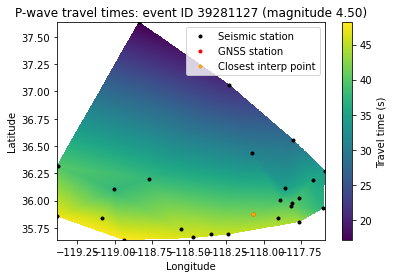

*** P740 P-waves ***
Distance (km) to closest interpolated point: 252.4371451487348
Interpolated GNSS travel time: nan


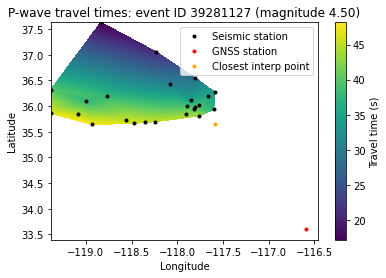

*** DLUZ P-waves ***
Distance (km) to closest interpolated point: 247.56408242386763
Interpolated GNSS travel time: nan


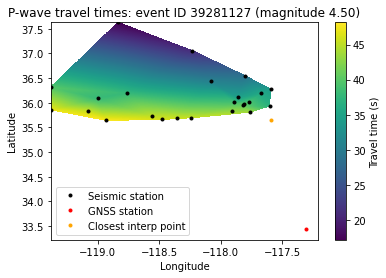

*** BEPK S-waves ***
Distance (km) to closest interpolated point: 74.59333526585667
Interpolated GNSS travel time: nan


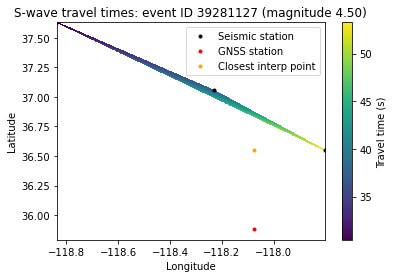

*** P740 S-waves ***
Distance (km) to closest interpolated point: 354.02407814921156
Interpolated GNSS travel time: 53.28


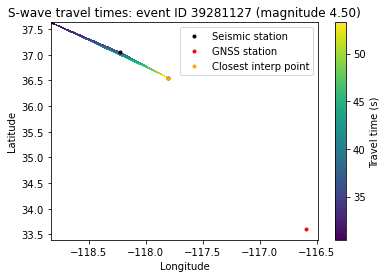

*** DLUZ S-waves ***
Distance (km) to closest interpolated point: 350.64373940837316
Interpolated GNSS travel time: 53.28


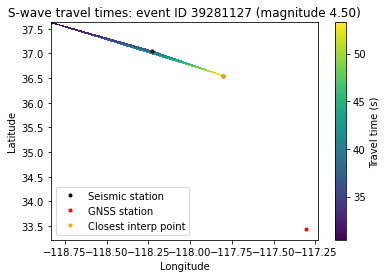

In [48]:
for kevent in range(len(event_catalog)):
    
    counter += 1

    event_ID = event_catalog[kevent,0]
    mag = event_catalog[kevent,5]
    
    print('----------------------')
    print('Event ' + str(event_ID) + ' (' + str(counter) + '/' + str(len(event_IDs)) + ')')

#     try:        
        
#         print('')
#         print('----------------------')
    print('P-waves')
#         print('----------------------')

    P_array = np.load(p_tt_dir + str(event_ID) + '.npy')
    # print(P_array)

    ###### Interpolate P-wave pick times ######

    P_latitude = np.asfarray(P_array[:,2])
    P_longitude = np.asfarray(P_array[:,3])
    P_travel_times = np.asfarray(P_array[:,4])

    P_interp_lat = np.linspace(min(P_latitude), max(P_latitude), num = 1000)
    P_interp_lon = np.linspace(min(P_longitude), max(P_longitude), num = 1000)

    P_interp_lon, P_interp_lat = np.meshgrid(P_interp_lon, P_interp_lat)

    P_interp = LinearNDInterpolator(list(zip(P_longitude, P_latitude)), P_travel_times)

    P_interp_tt = P_interp(P_interp_lon, P_interp_lat)

    ### Find values for GNSS stations ###

    GNSS_stas = np.genfromtxt(project_dir + 'GNSS_stas.txt', dtype = 'U')
#         print(GNSS_stas)

    if small_test:  
        GNSS_stas = GNSS_stas[[p,q,r],:][:,0,:]
#         print(GNSS_stas)

    GNSS_stacodes = GNSS_stas[:,2]
#     print(GNSS_stacodes)

    GNSS_P_tts = []
    GNSS_P_stas = []
    P_event_IDs = []
    P_dists_to_interp_pt_deg = []

    for kGsta in range(len(GNSS_stacodes)):

        P_dists = []
        lon_list = []
        lat_list = []

        GNSS_stacode = GNSS_stas[kGsta,2]
        print('*** ' + str(GNSS_stacode) + ' P-waves ***')

        GNSS_lon = float(GNSS_stas[kGsta,0])
        GNSS_lat = float(GNSS_stas[kGsta,1])

#             print('GNSS station location: (' + str(GNSS_lat) + ', ' + str(GNSS_lon) + ')')

        for i_lon in P_interp_lon[0]:

            # print(i_lon)

            for i_lat in P_interp_lat[:,0]:

                # print(i_lat)

                dist = np.sqrt((GNSS_lon - i_lon)**2 + (GNSS_lat - i_lat)**2)

                P_dists.append(dist)
                lon_list.append(i_lon)
                lat_list.append(i_lat)

        P_dists = np.array(P_dists)

        lon_array = np.array(lon_list)

        lat_array = np.array(lat_list)

        i = np.argmin(P_dists)

        P_dist_to_interp_pt_deg = [P_dists[i]]

        print('Distance (km) to closest interpolated point: ' + str(P_dists[i] * 111))
#             print('Interpolated point location: (' + str(lat_array[i]) + ', ' + str(lon_array[i]) + ')')

        a = np.where(P_interp_lon[0] == lon_array[i])[0]
        b = np.where(P_interp_lat[:,0] == lat_array[i])[0]

        GNSS_time = P_interp_tt[b,a][0]

        print('Interpolated GNSS travel time: ' + str(GNSS_time))

        GNSS_P_tts.append(GNSS_time)
        GNSS_P_stas.append(GNSS_stacode)
        P_event_IDs.append(event_ID)
        P_dists_to_interp_pt_deg.append(P_dist_to_interp_pt_deg)

        plt.pcolormesh(P_interp_lon, P_interp_lat, P_interp_tt, shading = 'auto')
        plt.plot(P_longitude, P_latitude, '.k', label = 'Seismic station')
        plt.plot(GNSS_lon, GNSS_lat, '.', color = 'red', label = 'GNSS station')
        plt.plot(lon_array[i], lat_array[i], '.', color = 'orange', label = 'Closest interp point')
        plt.plot()
        plt.legend()
        plt.colorbar(label = 'Travel time (s)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('P-wave travel times: event ID ' + str(event_ID) + ' (magnitude ' + str(mag) + ')')
        plt.show()
#             plt.savefig(interpplot_p_dir + str(event_ID) + '.png', format = 'PNG')
#             plt.close()

    # print(GNSS_P_tts)    
    # print(GNSS_P_stas)

    GNSS_P_array = np.column_stack((np.array(P_event_IDs), np.array(GNSS_P_stas), np.array(GNSS_P_tts), np.array(P_dists_to_interp_pt_deg)))

#         np.save(gnss_tt_p_dir + str(event_ID) + '.npy', GNSS_P_array)
        
#     except:
        
# #         print('P-wave error: event ID ' + str(event_ID))
#         nan_P_array = np.column_stack(('nan', 'nan', 'nan', 'nan'))
# #         np.save(gnss_tt_p_dir + str(event_ID) + '.npy', nan_P_array)

#     try:        
        
#         print('')
#         print('----------------------')
#         print('Event ' + str(event_ID) + ': S-waves')
#         print('----------------------')
        
    S_array = np.load(s_tt_dir + str(event_ID) + '.npy')
    # print(S_array)

    ###### Interpolate S-wave pick times ######

    S_latitude = np.asfarray(S_array[:,2])
    S_longitude = np.asfarray(S_array[:,3])
    S_travel_times = np.asfarray(S_array[:,4])

    S_interp_lat = np.linspace(min(S_latitude), max(S_latitude), num = 1000)
    S_interp_lon = np.linspace(min(S_longitude), max(S_longitude), num = 1000)

    S_interp_lon, S_interp_lat = np.meshgrid(S_interp_lon, S_interp_lat)

    S_interp = LinearNDInterpolator(list(zip(S_longitude, S_latitude)), S_travel_times)

    S_interp_tt = S_interp(S_interp_lon, S_interp_lat)

    ### Find values for GNSS stations ###

    GNSS_stas = np.genfromtxt(project_dir + 'GNSS_stas.txt', dtype = 'U')
    # print(GNSS_stas)
    
    if small_test:  
        GNSS_stas = GNSS_stas[[p,q,r],:][:,0,:]

    GNSS_stacodes = GNSS_stas[:,2]

    GNSS_S_tts = []
    GNSS_S_stas = []
    S_event_IDs = []
    S_dists_to_interp_pt_deg = []

    for kGsta in range(len(GNSS_stacodes)):

        S_dists = []
        lon_list = []
        lat_list = []

        GNSS_stacode = GNSS_stas[kGsta,2]
        print('*** ' + str(GNSS_stacode) + ' S-waves ***')

        GNSS_lon = float(GNSS_stas[kGsta,0])
        GNSS_lat = float(GNSS_stas[kGsta,1])

#             print('GNSS station location: (' + str(GNSS_lat) + ', ' + str(GNSS_lon) + ')')

        for i_lon in S_interp_lon[0]:

            # print(i_lon)

            for i_lat in S_interp_lat[:,0]:

                # print(i_lat)

                dist = np.sqrt((GNSS_lon - i_lon)**2 + (GNSS_lat - i_lat)**2)

                S_dists.append(dist)
                lon_list.append(i_lon)
                lat_list.append(i_lat)

        S_dists = np.array(S_dists)

        lon_array = np.array(lon_list)

        lat_array = np.array(lat_list)

        i = np.argmin(S_dists)

        S_dist_to_interp_pt_deg = [S_dists[i]]

        print('Distance (km) to closest interpolated point: ' + str(S_dists[i] * 111))
#             print('Interpolated point location: (' + str(lat_array[i]) + ', ' + str(lon_array[i]) + ')')

        a = np.where(S_interp_lon[0] == lon_array[i])[0]
        b = np.where(S_interp_lat[:,0] == lat_array[i])[0]

        GNSS_time = S_interp_tt[b,a][0]

        print('Interpolated GNSS travel time: ' + str(GNSS_time))

        GNSS_S_tts.append(GNSS_time)
        GNSS_S_stas.append(GNSS_stacode)
        S_event_IDs.append(event_ID)
        S_dists_to_interp_pt_deg.append(S_dist_to_interp_pt_deg)
        
        plt.pcolormesh(S_interp_lon, S_interp_lat, S_interp_tt, shading = 'auto')
        plt.plot(S_longitude, S_latitude, '.k', label = 'Seismic station')
        plt.plot(GNSS_lon, GNSS_lat, '.', color = 'red', label = 'GNSS station')
        plt.plot(lon_array[i], lat_array[i], '.', color = 'orange', label = 'Closest interp point')
        plt.plot()
        plt.legend()
        plt.colorbar(label = 'Travel time (s)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('S-wave travel times: event ID ' + str(event_ID) + ' (magnitude ' + str(mag) + ')')
        plt.show()

    # print(GNSS_S_tts)    
    # print(GNSS_S_stas)

    GNSS_S_array = np.column_stack((np.array(S_event_IDs), np.array(GNSS_S_stas), np.array(GNSS_S_tts), np.array(S_dists_to_interp_pt_deg)))

#     np.save(gnss_tt_s_dir + str(event_ID) + '.npy', GNSS_S_array) 

#     except:
        
# #         print('S-wave error: event ID ' + str(event_ID))
#         nan_S_array = np.column_stack(('nan', 'nan', 'nan', 'nan'))
#         np.save(gnss_tt_s_dir + str(event_ID) + '.npy', nan_S_array) 
    